In [265]:
import numpy as np
import pandas as pd 
from  scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pylab
from sklearn.preprocessing import StandardScaler

# 1. EDA

In [67]:
df = pd.read_csv("StudentsPerformance.csv")

In [68]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [70]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


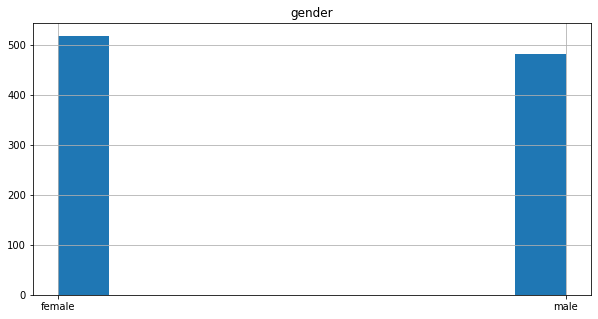

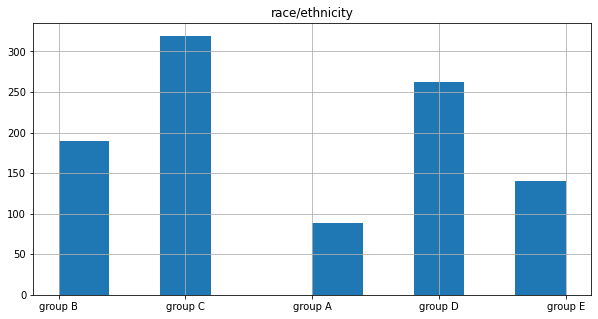

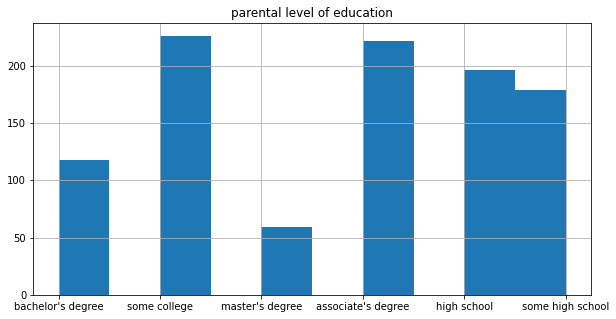

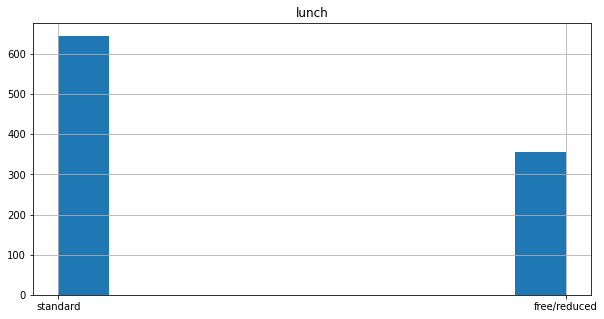

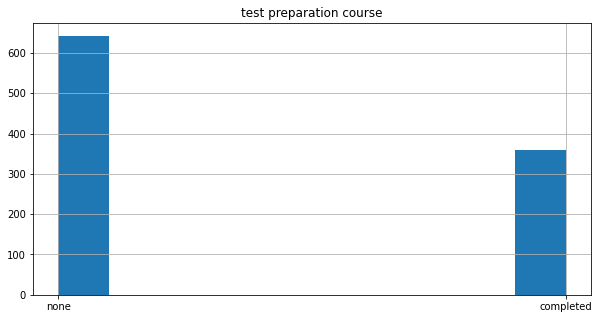

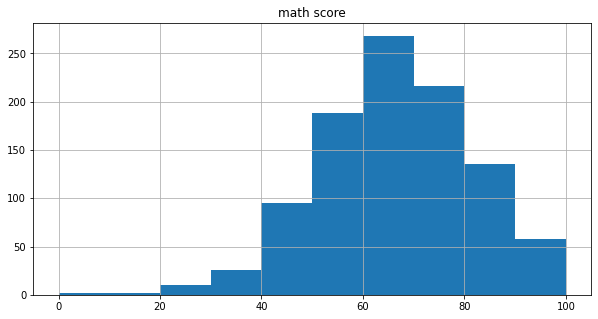

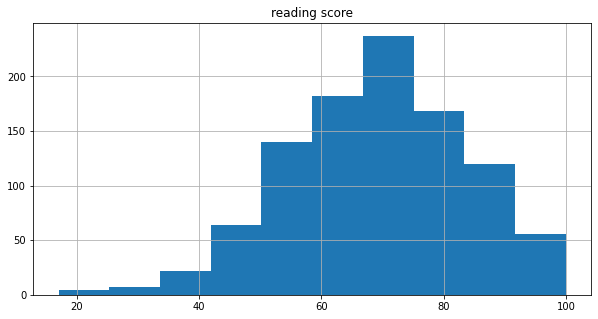

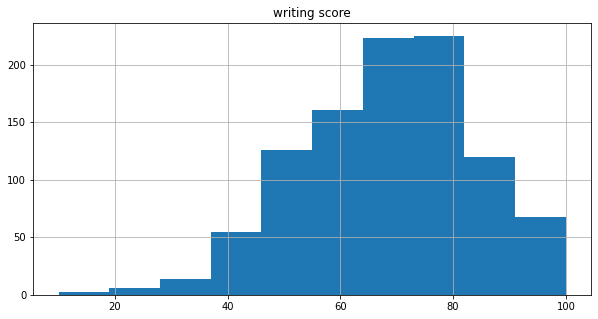

In [71]:
for x in df.columns:
    df[x].hist(figsize=(10,5))
    plt.title(x)
    plt.show()

In [73]:
education_dict ={'some high school':1, 'high school':2, 'some college':3, "associate's degree":4,
                "bachelor's degree": 5,  "master's degree": 6}
df['Ordinal_parental_education']=df['parental level of education'].map(education_dict)
df['is_male'] = df.gender == 'male'
df['has_lunch'] = df.lunch == 'standard'
df['has_prepared'] = df['test preparation course'] == 'completed'

In [74]:
dummies_race = pd.get_dummies(df['race/ethnicity'],prefix='race')
df_preprocessed = pd.concat([df, dummies_race],axis=1)
df_preprocessed = df_preprocessed.drop(columns=['gender', 'race/ethnicity',
                                                'parental level of education',
                                                'test preparation course', 
                                                'lunch', 'race_group B'], axis = 1) + 0

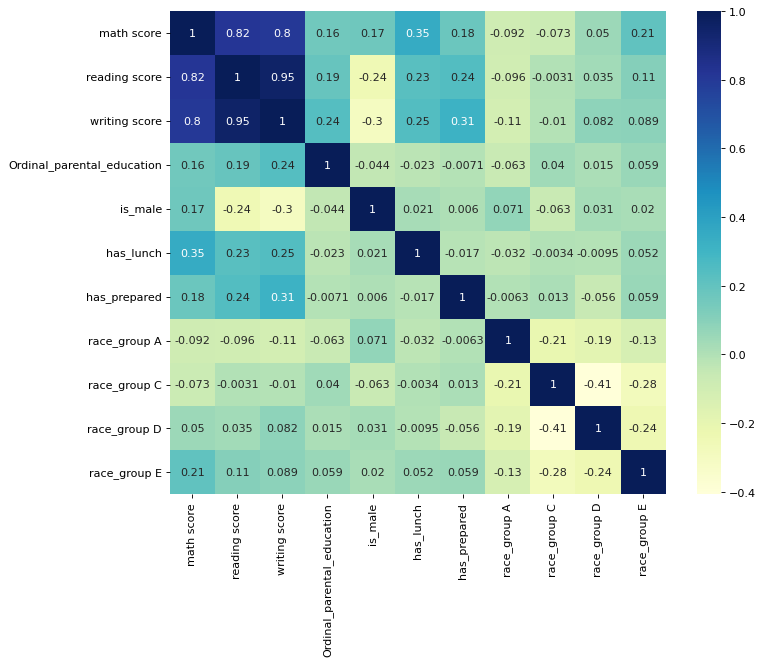

In [75]:
import seaborn as sns
plt.figure(figsize=(10, 8), dpi=80)

sns.heatmap(df_preprocessed.corr(), cmap="YlGnBu",  annot=True)
plt.show()

* Степень родителя влияет на способности к письму ребенка? 
* Результаты мужчин в письме хуже? 
* Плотный ланч положительно влияет на результаты теста по математике? 
* Подготовка к тесту по письму сильнее влияет на результат теста по письму, сравнимо с подготовкой по математике на результаты теста по математике? 
* Расовая группа E получает лучшие результаты по математике? 

### Будем воспринимать результат теста по 100 бальной шкале как непрерывную случайную величину

# 2. Regression analysis

In [77]:
X = sm.add_constant(df_preprocessed.drop(['math score', 'reading score', 'writing score'], axis = 1))
y_math = df_preprocessed['math score']
y_read = df_preprocessed['reading score']
y_write = df_preprocessed['writing score']

scaler = StandardScaler()
X[['Ordinal_parental_education', 'is_male', 'has_lunch',
       'has_prepared', 'race_group A', 'race_group C', 'race_group D',
       'race_group E']] = scaler.fit_transform(X[['Ordinal_parental_education', 'is_male', 'has_lunch',
       'has_prepared', 'race_group A', 'race_group C', 'race_group D',
       'race_group E']])

In [237]:
def get_subject_regression(y_subject):
    base_model = sm.OLS(y_subject, X)
    base_res = base_model.fit()
    base_rsquared = base_res.rsquared
    base_params = base_res.params[base_res.pvalues < 0.01][1:]
    pylab.scatter((base_res.predict(X) - y_subject).index, (base_res.predict(X) - y_subject))
    plt.title("{} residual plot".format(y_subject.name))
    plt.show()
    
    rsquared_change = np.array([])
    for feature in base_params.index:
        mod = sm.OLS(y_math, X.drop([feature], axis = 1))
        res = mod.fit()
        rsquared_change = np.append(rsquared_change, res.rsquared)
    rsquared_change = pd.Series(rsquared_change - base_rsquared)
    rsquared_change.index = base_params.index
    
    df_subject = pd.DataFrame({'Standart coefficients': base_params,'R_2_decrease':rsquared_change}).sort_values(by='Standart coefficients', ascending=False)
    
    return df_subject, base_rsquared

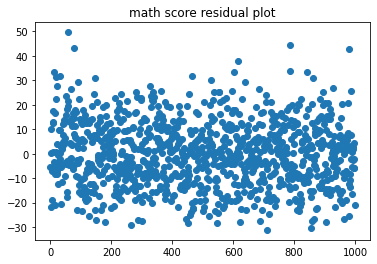

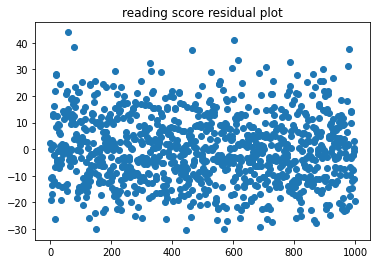

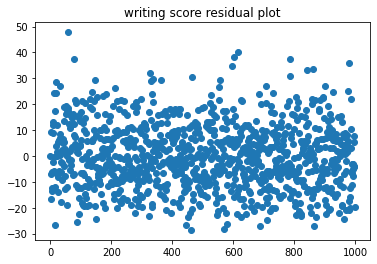

In [238]:
df_math, rsqared_math = get_subject_regression(y_math)
df_read, rsqared_read = get_subject_regression(y_read)
df_write, rsqared_write = get_subject_regression(y_write)

In [125]:
frames = [df_math, df_read, df_write]
pd.concat(frames, keys=["math, R^2 = {}".format(round(rsqared_math, 2)),  
                        "read, R^2 = {}".format(round(rsqared_read, 2)), 
                        "write, R^2 = {}".format(round(rsqared_write, 2))])

Standart coefficients  \
math, R^2 = 0.25  has_lunch                                5.215532   
                  race_group E                             2.855145   
                  has_prepared                             2.694040   
                  is_male                                  2.472980   
                  Ordinal_parental_education               2.432057   
                  race_group D                             1.524799   
read, R^2 = 0.22  has_prepared                             3.604465   
                  has_lunch                                3.473552   
                  Ordinal_parental_education               2.590241   
                  race_group E                             1.481609   
                  is_male                                 -3.564846   
write, R^2 = 0.33 has_prepared                             4.900870   
                  has_lunch                                3.932501   
                  Ordinal_parental_education               3.364697   
                  race_group D                             2.166734   
                  race_group E                             1.397651   
                  is_male                                 -4.578506   

                                              R_2_decrease  
math, R^2 = 0.25  has_lunch                      -0.117822  
                  race_group E                   -0.023482  
                  has_prepared                   -0.031407  
                  is_male                        -0.026326  
                  Ordinal_parental_education     -0.025381  
                  race_group D                   -0.005733  
read, R^2 = 0.22  has_prepared                   -0.004038  
                  has_lunch                      -0.090453  
                  Ordinal_parental_education      0.001988  
                  race_group E                    0.003887  
                  is_male                         0.001043  
write, R^2 = 0.33 has_prepared                   -0.109514  
                  has_lunch                      -0.195929  
                  Ordinal_parental_education     -0.103488  
                  race_group D                   -0.083840  
                  race_group E                   -0.101589  
                  is_male                        -0.104433

### Cтепень родителя влияет на способности к письму ребенка? 
* Standart coef = 3.36 
* R_2_decrease = -0.1 

Ответ: ДА

### Результаты мужчин в письме хуже? 
* Standart coef = -4.6 
* R_2_decrease = -0.1

Ответ: ДА
### Плотный ланч положительно влияет на результаты теста по математике? 
* Standart coef = 5.2
* R_2_decrease = -0.1

Ответ: ДА


### Подготовка к тесту по письму сильнее влияет на результат теста по письму, сравнимо с подготовкой по математике на результаты теста по математике? 
*  Standart coef_write = 4.9
* Standart coef_math = 2.7
* R_2_decrease_write = -0.1
* R_2_decrease_math = -0.03 


Ответ: ДА

### Расовая группа E получает лучшие результаты по математике? 
* Standart coef = 2.85
* R_2_decrease = -0.02 

Ответ: ДА

# 3. Есть ли значимая разница в результатах по математике между полами? (T-test)

In [24]:
male_math_score = df[df['is_male']]['math score']
female_math_score = df[df['is_male'] == False]['math score']

### У групп должна быть одинаковая дисперсия

- The Levene test tests the null hypothesis that all input samples are from populations with equal variances

In [25]:
statistic, pval = stats.levene(female_math_score, male_math_score)
if pval < 0.01:
    print("Отклоняем нулевую гипотезу - Разная дисперсия")
else:
    print("Принимаем нулевую гипотезу - Одинаковая дисперсия")

Принимаем нулевую гипотезу - Одинаковая дисперсия


### У групп должно быть нормальное распределение

- Гистограммы

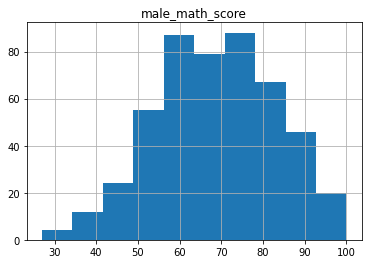

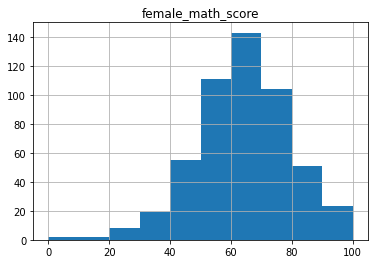

In [26]:
male_math_score.hist()
plt.title("male_math_score")
plt.show()
female_math_score.hist()
plt.title("female_math_score")
plt.show()

- qq plot

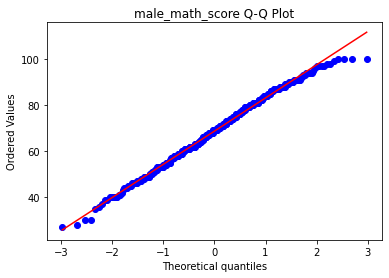

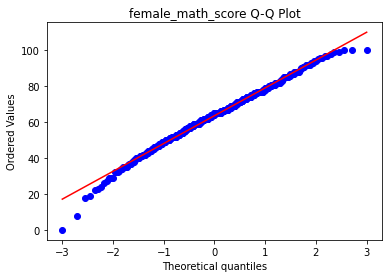

In [27]:
stats.probplot(male_math_score, dist="norm", plot= plt)
plt.title("male_math_score Q-Q Plot")
plt.show()
stats.probplot(female_math_score, dist="norm", plot= plt)
plt.title("female_math_score Q-Q Plot")
plt.show()

- The Shapiro–Wilk test a.k.a normality test

In [28]:
if stats.shapiro(male_math_score)[1] < 0.01:
    print("male_math_score is not normal")
else:
     print("male_math_score is normal")
        
if stats.shapiro(female_math_score)[1] < 0.01:
    print("female_math_score is not normal")
else:
     print("female_math_score is normal")

male_math_score is normal
female_math_score is not normal


- Тест Шапиро-Вилка показал, что женские баллы не нормальны, но судя по гистограмме и qq-плоту достаточная нормальность есть

In [29]:
ttest_pval = stats.ttest_ind(male_math_score, female_math_score)[1]
if ttest_pval < 0.01:
    print("Средние по группам отличаются")
else:
    print("Средние по группам одинаковы")

Средние по группам отличаются


### Есть значимое отличие в результатах теста по математике среди мужчин и женщин

# 4. Есть ли взаимосвязь между образованием родителей и расой человека? (Chi-squared test) 

In [30]:
education = df['parental level of education']
race = df['race/ethnicity']

In [31]:
education.value_counts()

some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64

In [32]:
race.value_counts()

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64

In [33]:
df_cross = pd.crosstab(education, race)
df_cross

race/ethnicity,group A,group B,group C,group D,group E
parental level of education,,,,,
associate's degree,14,41,78,50,39
bachelor's degree,12,20,40,28,18
high school,18,48,64,44,22
master's degree,3,6,19,23,8
some college,18,37,69,67,35
some high school,24,38,49,50,18


In [34]:
stats.chi2_contingency(df_cross)

(29.458661519097795,
 0.07911304840592047,
 20,
 array([[19.758, 42.18 , 70.818, 58.164, 31.08 ],
        [10.502, 22.42 , 37.642, 30.916, 16.52 ],
        [17.444, 37.24 , 62.524, 51.352, 27.44 ],
        [ 5.251, 11.21 , 18.821, 15.458,  8.26 ],
        [20.114, 42.94 , 72.094, 59.212, 31.64 ],
        [15.931, 34.01 , 57.101, 46.898, 25.06 ]]))

### Все частоты > 5 => результаты достоверны. 
### pvalue > 0.01 => принимаем нулевую гипотезу, т.е нет связи между расой и уровнем образования родителя

#  5. Степень родителя влияет на способности к письму ребенка? (T-test)


In [247]:
writing_educated_parents = df_preprocessed[df_preprocessed.Ordinal_parental_education > 3]['writing score']
writing_not_educated_parents = df_preprocessed[df_preprocessed.Ordinal_parental_education <= 3]['writing score']

Принимаем нулевую гипотезу - Одинаковая дисперсия
------------------------------------------------------------


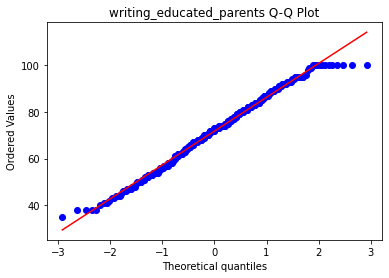

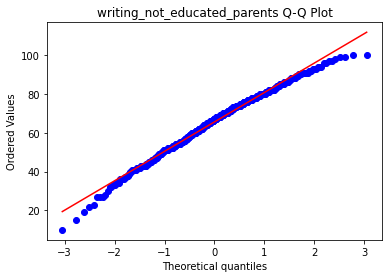

Средние по группам отличаются


In [255]:
statistic, pval = stats.levene(writing_educated_parents, writing_not_educated_parents)
if pval < 0.01:
    print("Отклоняем нулевую гипотезу - Разная дисперсия")
else:
    print("Принимаем нулевую гипотезу - Одинаковая дисперсия")
print('------------------------------------------------------------')
stats.probplot(writing_educated_parents, dist="norm", plot= plt)
plt.title("writing_educated_parents Q-Q Plot")
plt.show()
stats.probplot(writing_not_educated_parents, dist="norm", plot= plt)
plt.title("writing_not_educated_parents Q-Q Plot")
plt.show()

ttest_pval = stats.ttest_ind(writing_educated_parents, writing_not_educated_parents)[1]
if ttest_pval < 0.01:
    print("Средние по группам отличаются")
else:
    print("Средние по группам одинаковы")

### Степень родителя влияет на способности к письму ребенка

# 6. Результаты теста по математике отличаются между расой E и остальными (T-test)

In [257]:
math_race_E = df_preprocessed[df_preprocessed['race_group E'] == 1]['math score']
math_race_not_E  = df_preprocessed[df_preprocessed['race_group E'] == 0]['math score']

Принимаем нулевую гипотезу - Одинаковая дисперсия
------------------------------------------------------------


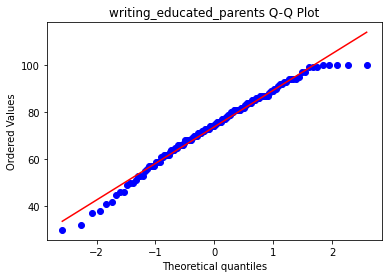

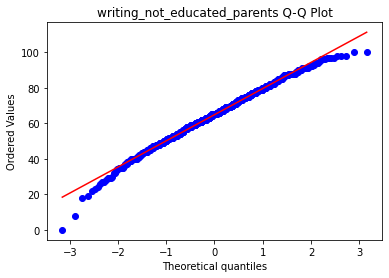

Средние по группам отличаются


In [264]:
statistic, pval = stats.levene(math_race_E, math_race_not_E)
if pval < 0.01:
    print("Отклоняем нулевую гипотезу - Разная дисперсия")
else:
    print("Принимаем нулевую гипотезу - Одинаковая дисперсия")
print('------------------------------------------------------------')
stats.probplot(math_race_E, dist="norm", plot= plt)
plt.title("writing_educated_parents Q-Q Plot")
plt.show()
stats.probplot(math_race_not_E, dist="norm", plot= plt)
plt.title("writing_not_educated_parents Q-Q Plot")
plt.show()

ttest_pval = stats.ttest_ind(math_race_E, math_race_not_E)[1]
if ttest_pval < 0.01:
    print("Средние по группам отличаются")
else:
    print("Средние по группам одинаковы")